In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import xgbfir
import ast
from tqdm.autonotebook import tqdm
import shap
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from datetime import date
from dateutil.relativedelta import relativedelta

from ModelProcessing.CategoricalEncoder import Encoder
from ModelProcessing.Filter_fights import Subset
from ModelProcessing.EvaluationPlots import LiftGainChart, BuildROCandPrecisionRecall
from ModelProcessing.GetDifferenceBetweenFighterAttributes import GetTheDifferenceBetweenFighterAttributes
from PreProcessing.Imputer import Imputer
pd.set_option('display.max_columns', 200)
import os
from pathlib import Path

BASE_PATH = Path(os.getcwd())

ufc = pd.read_csv(BASE_PATH/'data/engineered_features.csv')
print(ufc.shape)
ufc.tail()

(4310, 112)


R_fighter        B_fighter  Average_Odds_f1  Average_Odds_f2  \
4305       Song Yadong      Marlon Vera           -194.0            175.0   
4306       Eryk Anders  Krzysztof Jotko            111.0            100.0   
4307           Dan Ige    Edson Barboza            127.0           -119.0   
4308   Claudia Gadelha      Angela Hill           -225.0            225.0   
4309  Alistair Overeem      Walt Harris            138.0           -141.0   

            date  title_bout                win_by         weight_class  \
4305  2020-05-16       False  Decision - Unanimous        Featherweight   
4306  2020-05-16       False  Decision - Unanimous         Middleweight   
4307  2020-05-16       False      Decision - Split        Featherweight   
4308  2020-05-16       False      Decision - Split  Women's Strawweight   
4309  2020-05-16       False                KO/TKO          Heavyweight   

      red_fighters_elo  blue_fighters_elo  red_Fighter_Odds  \
4305       1387.772644        1366.682572          0.659864   
4306       1172.947076        1188.431846          0.473934   
4307       1365.731594        1321.063221          0.440529   
4308       1190.926597        1130.800206          0.692308   
4309       1255.593400        1158.000020          0.420168   

      blue_Fighter_Odds Winner  R_distance_beaten  R_distance_lost  \
4305           0.363636    Red           4.688339      9999.000000   
4306           0.500000   Blue           4.974107         5.272089   
4307           0.543379    Red           4.677205         5.649412   
4308           0.307692    Red           1.561584         3.257957   
4309           0.585062    Red           3.801080         4.665877   

      R_Fight_Number  R_Stance  R_Height_cms  R_Reach_cms  R_age  \
4305             5.0  Orthodox        172.72       170.18   22.0   
4306             9.0  Southpaw        185.42       190.50   33.0   
4307             7.0  Orthodox        170.18       180.34   28.0   
4308            11.0  Orthodox        162.56       160.02   31.0   
4309            17.0  Orthodox        193.04       203.20   39.0   

      R_WinLossRatio                                     R_Beaten_Names  \
4305        0.875000  ['Felipe Arantes', 'Vince Morales', 'Alejandro...   
4306        0.625000  ['Rafael Natal', 'Markus Perez', 'Tim Williams...   
4307        0.833333  ['Mike Santiago', 'Jordan Griffin', 'Danny Hen...   
4308        0.600000  ['Tina Lahdemaki', 'Jessica Aguilar', 'Cortney...   
4309        0.562500  ['Brock Lesnar', 'Frank Mir', 'Stefan Struve',...   

                                        R_Lost_to_names  R_RingRust  \
4305                                                 []   82.884257   
4306  ['Lyoto Machida', 'Thiago Santos', 'Elias Theo...   80.879540   
4307                                     ['Julio Arce']   74.926631   
4308  ['Joanna Jedrzejczyk', 'Joanna Jedrzejczyk', '...   96.298589   
4309  ['Antonio Silva', 'Travis Browne', 'Ben Rothwe...   92.473645   

      R_Winning_Streak  R_Losing_Streak  R_AVG_fight_time  \
4305               4.0              0.0         10.407500   
4306               2.0              0.0         12.892500   
4307               5.0              0.0         10.278333   
4308               1.0              0.0         14.803000   
4309               0.0              1.0          8.885000   

      R_total_title_bouts  R_Beaten_Similar  R_Takedown_Defense  \
4305             1.299802                 0            0.000000   
4306             0.000000                 0            0.742857   
4307             0.367768                 0            0.000000   
4308             1.000000                 2            0.775510   
4309             1.000000                 1            0.619048   

      R_Takedown Accuracy  R_Strikes_Per_Minute  R_Log_Striking_Ratio  \
4305             0.791667              1.000000             26.820221   
4306             0.312121              7.153711              0.499598   
4307             0.7400

In [44]:
def create_a_merge_column(df, fighter_one, fighter_two, date):
    
    df['merge'] = df[fighter_one] + df[fighter_two] 
    df['merge'] = df['merge'].apply(lambda x: x.replace(" ", "").replace(".",""))
    df['merge'] = df['merge'].apply(lambda x: ''.join(sorted(x)))
    df['merge'] = df['merge'] + df[date].astype(str)

    return(df)

data = pd.read_csv('C:/Users/egnke/PythonCode/UFC/Cost-Sensitive-Modeling-UFC/data/data.csv')

data = create_a_merge_column(data, 'R_fighter', 'B_fighter', 'date')
ufc = create_a_merge_column(ufc, 'R_fighter', 'B_fighter', 'date')
ufc = ufc.merge(data, on='merge',
                 how='left', suffixes=('', '_y'))
ufc.drop(ufc.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

In [45]:
# Subset Data
my_filter = Subset(ufc)
my_filter.subset_on_number_of_fights(number_of_fights=3)
my_filter.subset_on_draws
filtered_ufc = my_filter.df

# Encode Data
ufc_encoder = Encoder(filtered_ufc)
ufc_encoder.encode_weight_class
ufc_encoder.encode_title_bout
ufc_encoder.encode_winner
ufc_encoder.Difference_in_stances
encoded_ufc = ufc_encoder.df

# Impute missing values
imputer = Imputer(encoded_ufc)
cleaned_ufc = imputer.impute('bfill')
cleaned_ufc = imputer.impute_missing_values()

0%|          | 1/690 [00:00<01:24,  8.15it/s]Original Shape with all fights: (4310, 229)
New Shape with fighters over 3 fights (1607, 229)
Original Shape including Draws: (1607, 229)
New Shape with excluding draws(1579, 229)
100%|██████████| 690/690 [01:14<00:00,  9.32it/s]These Columns have Missing Values['R_distance_beaten', 'B_Takedown_Defense', 'B_distance_beaten', 'Referee']
Finished Imputation



In [46]:
def drop_cols(df):
    df = df.copy()
    df.drop(['R_fighter', 'B_fighter', 
                  'win_by','weight_class','Winner','B_Beaten_Names', 'B_Lost_to_names', 'R_Beaten_Names', 'R_Lost_to_names',
                  'B_Stats_of_Opponents_they_have_beaten',  'B_Stats_of_Opponents_they_have_lost_to',
                  'R_Stats_of_Opponents_they_have_beaten',  'R_Stats_of_Opponents_they_have_lost_to',],  axis=1, inplace=True)

    numeric_cols = df.select_dtypes([np.int, np.int64 , np.float, np.bool]).dtypes.index
    print('The following columns have been removed: '+ str(set(df.columns).symmetric_difference(numeric_cols)))
    
    new_df = df[numeric_cols]
    new_df['date'] = df['date']
    
    return new_df

ufc_cleaned = drop_cols(cleaned_ufc)

The following columns have been removed: {'merge', 'location', 'date', 'Referee'}


In [47]:
difference = GetTheDifferenceBetweenFighterAttributes(ufc_cleaned)
difference.get_difference_between_fighters_stats(cols_to_keep_whole=['fight_weight'])
ufc_cleaned = difference.get_data()

Training range: (2008-07-05 00:00:00, 2019-07-13 00:00:00)    (Test range: 2019-07-20 00:00:00, 2019-07-20 00:00:00)
Training range: (2008-07-05 00:00:00, 2019-07-20 00:00:00)    (Test range: 2019-07-27 00:00:00, 2019-07-27 00:00:00)
Training range: (2008-07-05 00:00:00, 2019-07-27 00:00:00)    (Test range: 2019-08-03 00:00:00, 2019-08-03 00:00:00)
Training range: (2008-07-05 00:00:00, 2019-08-03 00:00:00)    (Test range: 2019-08-10 00:00:00, 2019-08-10 00:00:00)
Training range: (2008-07-05 00:00:00, 2019-08-10 00:00:00)    (Test range: 2019-08-17 00:00:00, 2019-08-17 00:00:00)
Training range: (2008-07-05 00:00:00, 2019-08-17 00:00:00)    (Test range: 2019-08-31 00:00:00, 2019-08-31 00:00:00)
Training range: (2008-07-05 00:00:00, 2019-08-31 00:00:00)    (Test range: 2019-09-07 00:00:00, 2019-09-07 00:00:00)
Training range: (2008-07-05 00:00:00, 2019-09-07 00:00:00)    (Test range: 2019-09-14 00:00:00, 2019-09-14 00:00:00)
Training range: (2008-07-05 00:00:00, 2019-09-14 00:00:00)    (T

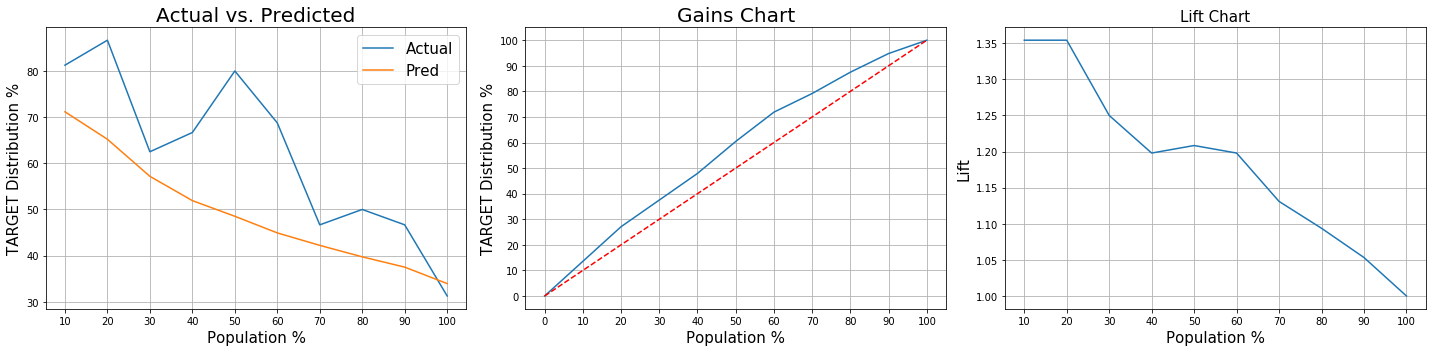

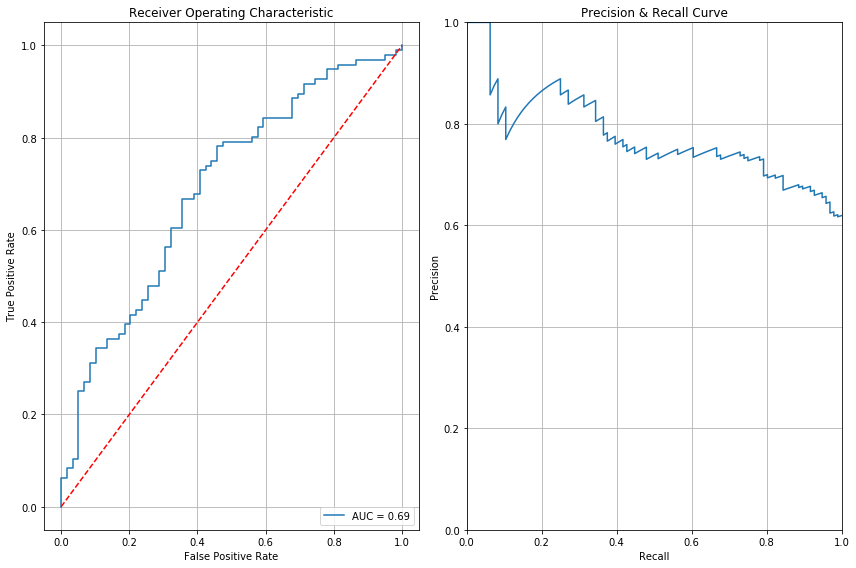

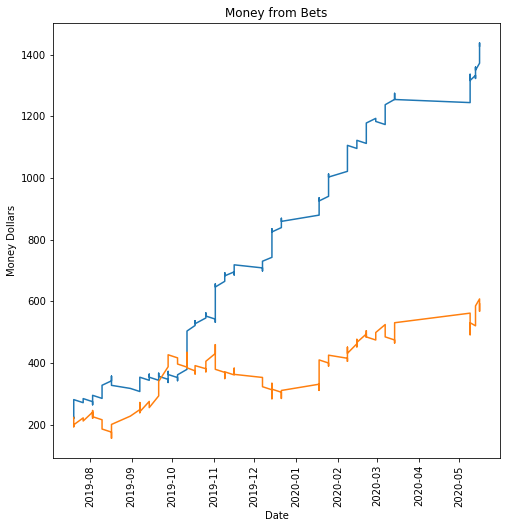

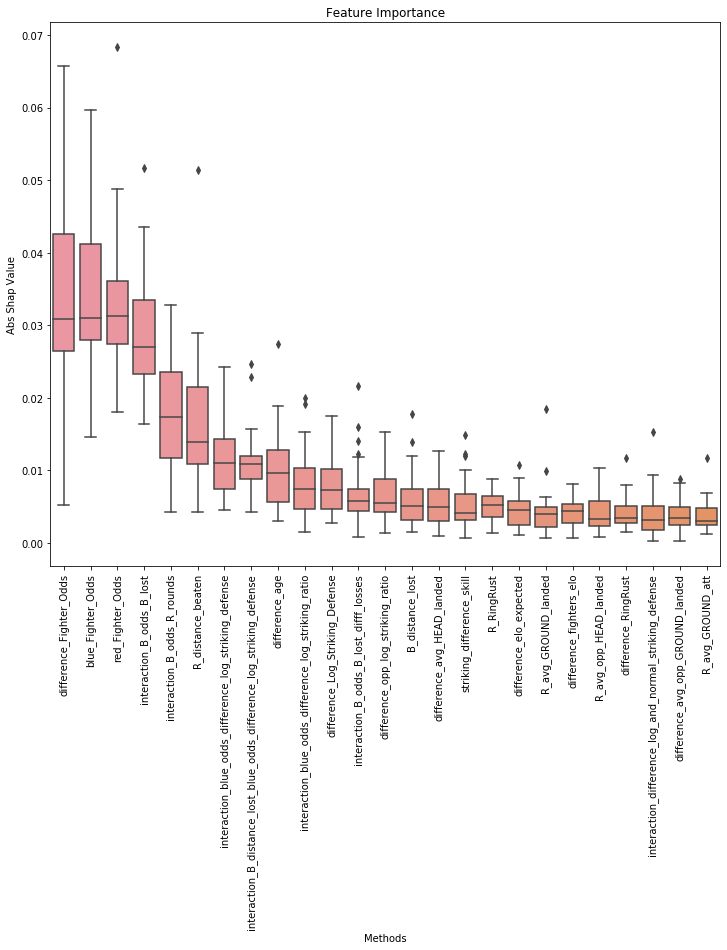

In [98]:
class Bookies:


    def __init__(self, initial_pot):
        self.pot = initial_pot



    def Place_bet(self, stake, red_fighter_odds, blue_fighter_odds, prediction, winner):


        if prediction == winner:

            if prediction == 1:
                winnings = self.Calculate_Winnings(stake, red_fighter_odds)
                payout   = winnings
                self.pot = self.pot + payout

            else:
                winnings = self.Calculate_Winnings(stake, blue_fighter_odds)
                payout   = winnings
                self.pot = self.pot + payout
        

        else:
            self.pot = self.pot - stake


        return self.pot



    @staticmethod
    def Calculate_Winnings(stake, odds):

        if odds > 0:
            winnings = (stake*odds)/100

        else:
            winnings = (stake/odds) * 100

        return abs(winnings) + stake


class BackTest:
    

    def __init__(self, df, model, date_range, y, sample_weights = False):

        self.model = model
        self.date_range = date_range
        self.sample_weights = sample_weights
        self.df = df.copy()
        self.df = self.create_datetime_index(self.df, 'date')
        self.most_recent_date = self.df.index.max()
        self.dates = self.df.index.unique().to_list()
        self.y = y


    @staticmethod
    def create_datetime_index(df, date_col):

        if not date_col in df.columns:
            raise AttributeError('The column ' + str(date_col) + ' does not exist!')

        datetime_series = pd.to_datetime(df[date_col])
        datetime_index = pd.DatetimeIndex(datetime_series.values)
        df.set_index(datetime_index, inplace=True)
        df.drop(date_col, axis=1, inplace=True)
        return df


    @staticmethod
    def check_if_tuple(obj):

        if isinstance(obj, tuple):
            return True
        else:
            return False

    
    def initlize_index(self):

        df = self.df.copy()
        if self.check_if_tuple(self.date_range):

            filtered_df = df[self.date_range[0]:self.date_range[1]]
            index = self.dates.index(max(filtered_df.index))

            return index

        else:

            filtered_df = df[:self.date_range]
            index = self.dates.index(max(filtered_df.index))

            return index


    def filter_data_by_index(self, df, date_range):

        df = df.copy()
        if self.check_if_tuple(date_range):

            X_train = df[date_range[0]:date_range[1]]
            y_train = X_train.pop(self.y)

            index = self.dates.index(max(X_train.index))
            X_test = df[self.dates[index+1]:self.dates[index+1]]
            y_test = X_test.pop(self.y)

            weights = X_train.pop('fight_weight')
            X_test.pop('fight_weight')

            return X_train, X_test, y_train, y_test, index, weights

        else:

            X_train = df[:date_range]
            y_train = X_train.pop(self.y)

            index = self.dates.index(max(X_train.index))
            X_test = df[self.dates[index+1]:self.dates[index+1]]
            y_test = X_test.pop(self.y)

            weights = X_train.pop('fight_weight')
            X_test.pop('fight_weight')


            return X_train, X_test, y_train, y_test, index, weights


    def update_date_range(self, date_range, index):

        if self.check_if_tuple(date_range):
            new_date   = self.dates[index+1]
            new_date_range = (date_range[0], new_date)
            return new_date_range

        else:
            new_date   = self.dates[index+1]
            new_date_range = new_date
            return new_date_range


    @staticmethod
    def place_bets(row, bookie, stake, favourite=False):

        if favourite:

            return bookie.Place_bet(stake=stake, red_fighter_odds=row['Red Odds'],
                    blue_fighter_odds=row['Blue Odds'], prediction=row['Favourite'], winner=row['Actual'])
        
        else:

            return bookie.Place_bet(stake=stake, red_fighter_odds=row['Red Odds'],
                    blue_fighter_odds=row['Blue Odds'], prediction=row['Predicted'], winner=row['Actual'])


    @staticmethod
    def get_shap_values(model, values):

        explainer   = shap.TreeExplainer(model, feature_perturbation = "tree_path_dependent")
        shap_values = np.array(explainer.shap_values(values))

        if len(shap_values.shape) == 3:
            shap_values = np.abs(shap_values).sum(axis=0)
            shap_values = shap_values.mean(0)
        
        else:
            shap_values = np.abs(shap_values).mean(0)

        return shap_values

    @staticmethod
    def plot(data):

        plt.figure(figsize=(12, 10))
        data['index'] = data.index
        data = pd.melt(data, id_vars='index', var_name='Methods')
        order = data.groupby(by=["Methods"])["value"].mean().sort_values(ascending=False).indexorder = data.groupby(by=["Methods"])["value"].mean().sort_values(ascending=False).index

        data = data[data["Methods"].isin(order[:25])]
        ax = sns.boxplot(x=data["Methods"], y=data["value"],
                                order=order)

        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, size=10)
        ax.set_title('Feature Importance')
        ax.set_ylabel('Abs Shap Value')
        plt.plot()
 


    def fit(self):

        index = self.initlize_index()
        probas = []
        y_true = []
        red_fighter_odds  = []
        blue_fighter_odds = []
        date = []

        importances = []
        while self.dates[index+1] != self.most_recent_date:
            
            X_train, X_test, y_train, y_test, index, weights = self.filter_data_by_index(self.df, self.date_range)

            X_train.pop('Average_Odds_f1')
            X_train.pop('Average_Odds_f2')

            date.append(X_test.index.values)
            red_fighter_odds.append(X_test.pop('Average_Odds_f1'))
            blue_fighter_odds.append(X_test.pop('Average_Odds_f2'))


            if self.sample_weights == True:
                probabilities = self.model.fit(X_train, y_train, sample_weight=weights).predict_proba(X_test)[:,1]
            else:
                probabilities = self.model.fit(X_train, y_train).predict_proba(X_test)[:,1]

            probas.append(probabilities)
            y_true.append(y_test.values)

            importances.append(self.get_shap_values(self.model, X_test))

            self.date_range = self.update_date_range(self.date_range, index)
            
            print('Training range: (' + str(X_train.index.min()) +  ', ' + str(X_train.index.max()) +')' + '    (Test range: ' \
                   + str(X_test.index.min()) + ', ' + str(X_test.index.max()) +')' )


        date = np.concatenate(date).ravel()
        y_true = np.concatenate(y_true).ravel()
        probas = np.concatenate(probas).ravel()
        red_fighter_odds  = np.concatenate(red_fighter_odds).ravel()
        blue_fighter_odds = np.concatenate(blue_fighter_odds).ravel()

        preds = np.where(probas > 0.4, 1, 0)
        print(f'{classification_report(y_true, preds)}')

        LiftGainChart(y_true=y_true, probas=probas)
        BuildROCandPrecisionRecall(y_true=y_true, probas=probas)


        data = pd.DataFrame({
                      'Date':date,
                      'Actual':y_true,
                      'Predicted':preds,
                      'Probas':probas,
                      'Red Odds': red_fighter_odds,
                      'Blue Odds': blue_fighter_odds})

        data['Favourite'] = np.where(data['Red Odds'] > data['Blue Odds'], 1, 0)

        bookie = Bookies(initial_pot=200)
        data['My_Money_Model'] = data.apply(lambda x: self.place_bets(x, bookie, 10, favourite=False), axis=1)

        bookie2 = Bookies(initial_pot=200)
        data['My_Money_Fav'] = data.apply(lambda x: self.place_bets(x, bookie2, 10, favourite=True), axis=1)

        plt.figure(figsize=(8, 8))
        plt.title('Money from Bets')
        plt.ylabel('Money Dollars')
        plt.xlabel('Date')
        plt.plot(data['Date'], data['My_Money_Model'])
        plt.plot(data['Date'], data['My_Money_Fav'])
        plt.xticks(rotation='vertical')
        plt.show()


        importance_data = np.stack(importances, axis=0)
        importance_data = pd.DataFrame(importance_data, columns=X_test.columns.to_list())

        self.plot(importance_data)
        


ufc_cleaned['interaction_blue_odds_difference_log_striking_defense'] = ufc_cleaned['blue_Fighter_Odds'] * ufc_cleaned['difference_Log_Striking_Defense']

ufc_cleaned['interaction_blue_odds_difference_log_striking_ratio'] = ufc_cleaned['blue_Fighter_Odds'] * ufc_cleaned['difference_Log_Striking_Ratio']


ufc_cleaned['interaction_blue_odds_difference_log_striking_ratio_diff_leg_attacks'] = ufc_cleaned['blue_Fighter_Odds'] * ufc_cleaned['difference_Log_Striking_Ratio']*ufc_cleaned['B_avg_opp_LEG_landed']


ufc_cleaned['interaction_B_distance_lost_blue_odds_difference_log_striking_defense'] =  ufc_cleaned['blue_Fighter_Odds']*ufc_cleaned['B_distance_lost']*ufc_cleaned['difference_Log_Striking_Defense']

ufc_cleaned['interaction_difference_log_and_normal_striking_defense'] =  ufc_cleaned['difference_Striking Defense']*ufc_cleaned['difference_Log_Striking_Defense']



ufc_cleaned['interaction_B_odds_B_lost'] = ufc_cleaned['blue_Fighter_Odds'] * ufc_cleaned['B_distance_lost']
ufc_cleaned['interaction_B_odds_R_rounds'] = ufc_cleaned['R_total_rounds_fought'] * ufc_cleaned['blue_Fighter_Odds']
ufc_cleaned['interaction_B_odds_B_lost_difff_losses'] = ufc_cleaned['blue_Fighter_Odds'] * ufc_cleaned['B_distance_lost']* ufc_cleaned['difference_losses']
ufc_cleaned['interaction_B_strikes_per_min_red_wrestling'] = ufc_cleaned['wrestling_red_skill']*ufc_cleaned['B_Strikes_Per_Minute']

six_months_ago = date.today() + relativedelta(months=-12)
#model = RandomForestClassifier(criterion='gini', max_depth=4, random_state=40)
model = RandomForestClassifier(criterion='gini', max_depth=4, class_weight='balanced')
#model = XGBClassifier(max_depth=4)
backtest = BackTest(ufc_cleaned, model, date_range=six_months_ago, y='Winner_encoded', sample_weights=False)
data = backtest.fit()

In [78]:
def check(clf, X, y):

    print(f'{classification_report(y, clf.predict(X))}')
    shap.initjs()
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X)
    return shap.summary_plot(shap_values[1], X, plot_type='dot')


def cross_validate_catboost(X, y, **kwargs):
    import catboost, utils
    models = cross_validate(
             catboost.CatBoostClassifier(od_type='Iter',
                                         od_wait=10,
                                         eval_metric='AUC', 
                                         **kwargs
                                         ),
                             X, y,
                             fit=lambda m,Xt,yt,Xv,yv: m.fit(Xt, yt, eval_set=(Xv,yv),
                             cat_features=np.where(X.dtypes == 'category')[0],
                             verbose=0))
                             
    return pd.DataFrame(models)


def balancing_params(y):
    counts = y.value_counts()
    return { 'class_names': list(counts.index), 'class_weights': len(y) / counts.values }



X = ufc_cleaned.copy()
X.pop('date')
y = X.pop('Winner_encoded')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
model_forest = RandomForestClassifier(criterion='gini', max_depth=4, class_weight='balanced')
model_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

precision    recall  f1-score   support

           0       0.85      0.52      0.65       503
           1       0.75      0.94      0.83       760

    accuracy                           0.77      1263
   macro avg       0.80      0.73      0.74      1263
weighted avg       0.79      0.77      0.76      1263



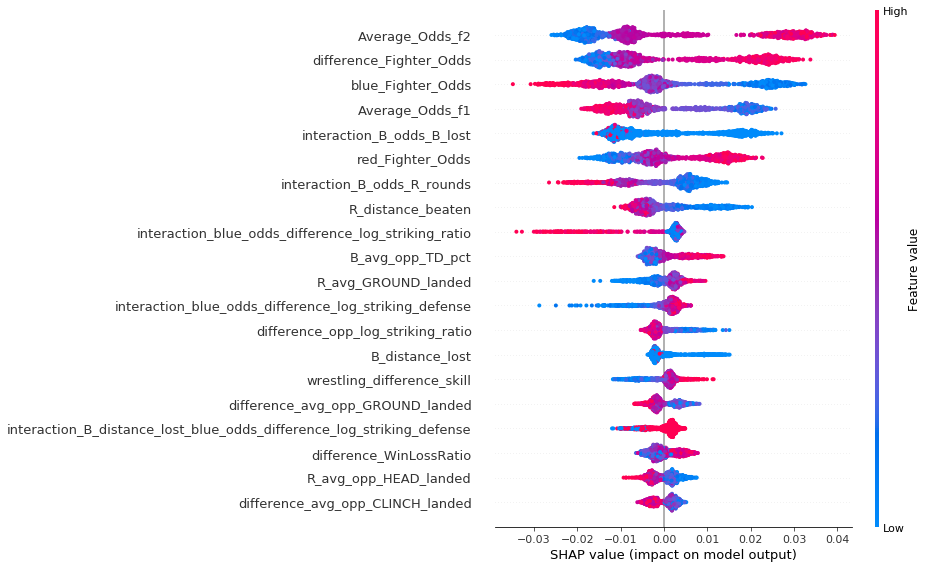

In [79]:
check(model_forest, X_train, y_train)

precision    recall  f1-score   support

           0       0.70      0.33      0.45       141
           1       0.62      0.89      0.73       175

    accuracy                           0.64       316
   macro avg       0.66      0.61      0.59       316
weighted avg       0.66      0.64      0.61       316



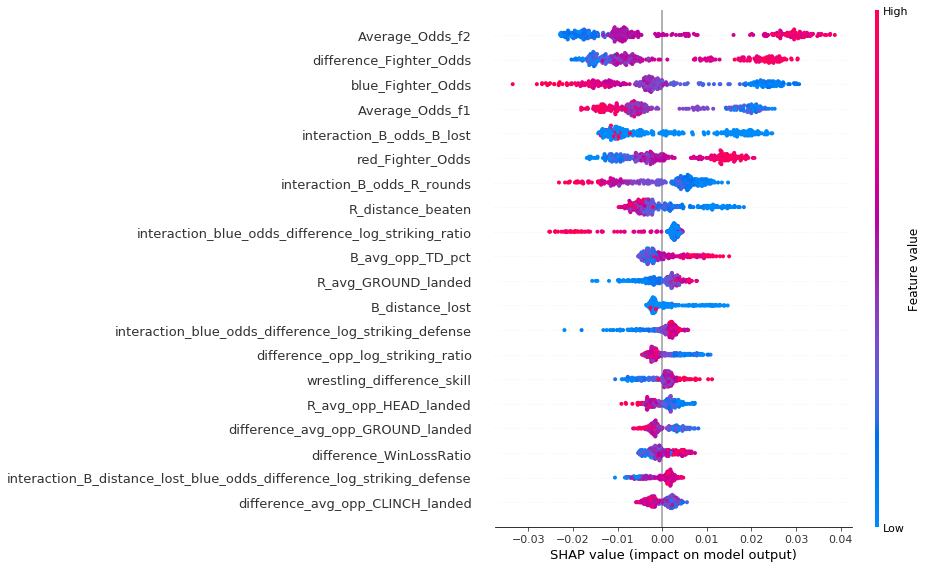

In [80]:
check(model_forest, X_test, y_test)

In [66]:
from sklearn.metrics import accuracy_score

space={'max_depth': hp.quniform("max_depth", 3, 8, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180
    }


def hyperparameter_tuning(space):

    clf=XGBClassifier(n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                         reg_alpha = int(space['reg_alpha']), min_child_weight=space['min_child_weight'],
                         colsample_bytree=space['colsample_bytree'])
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred > 0.5)
    print ("SCORE:", accuracy)
    #change the metric if you like
    return {'loss': -accuracy, 'status': STATUS_OK }


trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print (best)

100%|██████████| 100/100 [00:46<00:00,  2.17trial/s, best loss: -0.6487341772151899]
{'colsample_bytree': 0.9445266736769765, 'gamma': 2.149639888963404, 'max_depth': 6.0, 'min_child_weight': 9.0, 'reg_alpha': 41.0, 'reg_lambda': 0.5437747039226133}


In [56]:
test = ufc.copy()
test['Elo_winner'] = np.where(test['R_elo_expected'] > test['B_elo_expected'], 1, 0)
ufc.tail()

B_Stance  B_Height_cms  B_Reach_cms  B_age  \
4305            23.0  Orthodox        180.34       190.50   34.0   
4306            14.0  Orthodox        160.02       162.56   35.0   
4307             5.0  Orthodox        167.64       175.26   33.0   
4308             2.0  Orthodox        175.26       182.88   31.0   
4309            12.0  Southpaw        195.58       195.58   36.0   

      B_WinLossRatio  B_RingRust  B_Winning_Streak  B_Beaten_Similar  \
4305        0.636364   65.114311               0.0                 0   
4306        0.461538  119.932513               3.0                 0   
4307        0.500000  145.273191               0.0                 0   
4308        0.000000   79.195959               0.0                 0   
4309        0.545455  140.714707               4.0                 0   

      B_Losing_Streak  B_AVG_fight_time  B_total_title_bouts  \
4305              2.0         11.050000                  0.0   
4306              0.0         12.502308                  0.0   
4307              1.0         11.000000                  0.0   
4308              1.0               NaN                  0.0   
4309              0.0          6.165455                  0.0   

      B_Takedown_Defense  B_Takedown Accuracy  B_distance_beaten  \
4305            0.790726             0.363636           5.275290   
4306            0.541667             0.708333           3.830236   
4307            0.750000             0.516667           3.702734   
4308                 NaN                  NaN        9999.000000   
4309            0.735000             0.761905           4.686816   

      B_distance_lost  B_Strikes_Per_Minute  B_Striking Accuracy  \
4305         4.583176              8.391682             0.455230   
4306         2.884138              6.916503             0.461628   
4307         2.012612              3.672056             0.407340   
4308         2.929251                   NaN                  NaN   
4309         4.859632             10.441600             0.370594   

      B_Log_Striking_Ratio  B_Strikes_Absorbed_per_Minute  B_Striking Defense  \
4305              0.230896                       4.415949            0.592981   
4306              0.081435                       5.250654            0.631172   
4307             -0.296435                       2.256894            0.793759   
4308             -0.257065                            NaN                 NaN   
4309              0.869234                       6.700818            0.653076   

      B_knockdows_per_minute  B_Submission Attempts  B_Average_Num_Takedowns  \
4305                0.068886               0.045455                 0.495580   
4306                0.005128               0.153846                 0.509221   
4307                0.000000               1.476378                 2.553603   
4308                     NaN                    NaN                      NaN   
4309                0.864204               0.090909                 0.408773   

      B_win_by_Decision_Majority  B_win_by_Decision_Split  \
4305                    0.043478                 0.043478   
4306                    0.000000                 0.000000   
4307                    0.000000                 0.200000   
4308                    0.000000                 0.000000   
4309                    0.000000                 0.000000   

      B_win_by_Decision_Unanimous  B_win_by_KO/TKO  B_win_by_Submission  \
4305                     0.217391         0.304348                  0.0   
4306                     0.357143         0.071429                  0.0   
4307                     0.000000         0.000000                  0.2   
4308                     0.000000         0.000000                  0.0   
4309                     0.000000         0.500000                  0.0   

      B_win_by_TKO_Doctor_Stoppage  B_Power_Rating  blue_skill  \
4305                      0.000000        0.143873   35.216548   
4306                      0.071429        0.002467   24.008

precision    recall  f1-score   support

           0       0.63      0.76      0.69       125
           1       0.82      0.71      0.76       191

    accuracy                           0.73       316
   macro avg       0.72      0.73      0.72       316
weighted avg       0.74      0.73      0.73       316



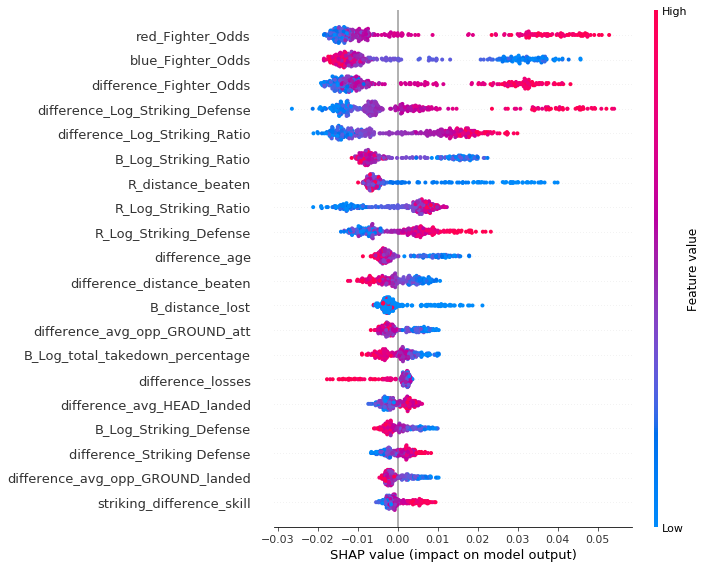

In [182]:
check(model_forest, X_test, y_test)

In [24]:
X[['difference_Fighter_Odds','difference_Log_Striking_Ratio','difference_Log_Striking_Defense',
                    'difference_age', 'difference_RingRust','striking_difference_skill','difference_fighters_elo','difference_Takedown_Defense',
                    'wrestling_difference_skill','difference_Power_Rating','g_and_p_difference_skill','jiujitsu_difference_skill','R_win_by_KO/TKO']]

difference_Fighter_Odds  difference_Log_Striking_Ratio  \
169                  0.472990                       1.102452   
171                  0.136033                       0.197858   
189                  0.178641                       0.786744   
198                 -0.412069                       1.491458   
219                  0.506691                       0.026617   
...                       ...                            ...   
4305                -0.102850                       0.090622   
4307                 0.246680                       0.823087   
4303                 0.296228                       1.003269   
4304                -0.026066                      -0.619278   
4309                -0.164894                       0.257174   

      difference_Log_Striking_Defense  difference_age  difference_RingRust  \
169                         -0.039221           -10.0            10.883437   
171                         -0.115100            -7.0             8.403500   
189                          0.361191             7.0           -20.753831   
198                          0.287114             6.0            13.129770   
219                          0.232953             6.0            -7.816285   
...                               ...             ...                  ...   
4305                         0.061686            -6.0             9.812320   
4307                        -0.377351             0.0            -6.556693   
4303                         0.194499            -5.0             1.080584   
4304                        -0.208212             3.0           -31.262787   
4309                        -0.133221             3.0           -48.241062   

      striking_difference_skill  difference_fighters_elo  \
169                    9.588448                24.195311   
171                    1.864602                 2.521583   
189                    6.780566                 7.033930   
198                    4.981481                -3.852588   
219                    2.112408                66.823918   
...                         ...                      ...   
4305                  -1.486498               -14.705249   
4307                   3.541576                23.094774   
4303                   0.240543               -77.534748   
4304                  -0.160089                11.790678   
4309                   3.579476                10.774048   

      difference_Takedown_Defense  wrestling_difference_skill  \
169                     -0.493386                    1.979016   
171                     -0.083333                    0.980880   
189                     -0.107071                    6.786315   
198                     -0.055556                   -1.961440   
219                      0.498932                    9.787561   
...                           ...                         ...   
4305                    -0.050726                    0.000990   
4307                    -0.475000                   -9.751309   
4303                     0.089021                    0.530992   
4304                    -0.078720                    0.878551   
4309                    -0.115952                   -5.861912   

      difference_Power_Rating  g_and_p_difference_skill  \
169                 -0.111111                  3.408491   
171                  0.110317                  1.864602   
189                 -0.045834                  6.148363   
198                  0.016667                  8.021881   
219                 -0.027775                 -3.338966   
...                       ...                       ...   
4305                -0.098993                 15.771376   
4307                 0.018251                 -4.034090   
4303                -0.003991                  7.918364   
4304                 0.032938                 -8.017109   
4309                 0.268679                 -3.866091   

      jiujitsu_difference_skill  R_win_by_KO/TKO  
169                  -15.063475       

In [90]:
data = pd.read_csv('C:/Users/egnke/PythonCode/UFC/Cost-Sensitive-Modeling-UFC/data/data.csv',sep=',')

In [93]:
data[(data.R_fighter == 'Jon Jones') | (data.B_fighter == 'Jon Jones')]

9.071429                 4.714286   
3157               4.076923              9.384615                 4.923077   
3301               3.916667              9.333333                 4.833333   
3527               4.000000              9.636364                 4.909091   
3673               3.100000              9.500000                 4.800000   
3780               3.222222             10.222222                 5.333333   
3866               3.000000             10.375000                 5.625000   
4002               8.200000              7.800000                 5.000000   
4039               3.666667             13.166667                 7.333333   
4176               4.400000             15.800000                 8.800000   
4271               5.000000             19.545455                13.090909   
4335               4.875000              7.250000                 3.250000   
4428              10.500000             38.500000                21.500000   
4520              11.000000             41.000000                15.000000   
4624                    NaN                   NaN                      NaN   

      R_avg_opp_DISTANCE_att  R_avg_opp_DISTANCE_landed  R_avg_opp_GROUND_att  \
92                 75.142857                  23.333333              0.523810   
385                70.950000                  22.400000              0.550000   
569                71.578947                  21.947368              0.578947   
643                71.111111                  22.111111              0.611111   
1313               67.222222                  26.111111              1.111111   
1931               63.375000                  19.125000              0.687500   
2529               59.533333                  18.066667              0.600000   
2890               54.142857                  17.214286              0.642857   
3157               36.538462                  10.230769              0.692308   
3301               39.166667                  11.083333              0.750000   
3527               40.181818                  11.090909              0.636364   
3673               30.500000                   8.300000              0.400000   
3780               30.000000                   7.777778              0.444444   
3866               29.375000                   7.125000              0.500000   
4002               45.800000                  14.000000             17.400000   
4039               29.166667                   7.333333              0.666667   
4176               34.000000                   8.800000              0.800000   
4271               33.454545                   9.454545              4.454545   
4335               64.000000                  24.875000              0.875000   
4428               41.000000                  13.500000              0.500000   
4520               43.000000                  19.000000              0.000000   
4624                     NaN                        NaN                   NaN   

      R_avg_opp_GROUND_landed  R_avg_opp_HEAD_att  R_avg_opp_HEAD_landed  \
92                   0.285714           63.142857              15.190476   
385                  0.300000           61.700000              15.500000   
569                  0.315789           62.842105              15.526316   
643                  0.333333           62.888889              15.722222   
1313                 0.777778           61.222222              20.666667   
1931                 0.375000           57.500000              14.062500   
2529                 0.333333           52.666667              12.333333   
2890                 0.357143           45.428571              10.785714   
3157                 0.384615           33.230769               6.769231   
3301                 0.416667           35.583333               7.333333   
3527                 0.363636           36.454545               7.272727   
3673                 0.400000           29.700000               6.400000   
3780              

In [43]:
from math import log

def split_of_from_stat(one_of_two):
    split_sentence = one_of_two.split()
    success   = int(split_sentence[0])
    attempts = int(split_sentence[-1])
    return(success,attempts)


def log_striking(row):


    if row.win_by == 'KO/TKO':
        return(row.Winner)
    

    else:
        red_significant_strikes_landed,  red_total_sig_strikes_thrown = split_of_from_stat(row['R_SIG_STR.'])
        blue_significant_strikes_landed, blue_total_sig_strikes_thrown = split_of_from_stat(row['B_SIG_STR.'])


        try:
            red_log = log(red_significant_strikes_landed/red_total_sig_strikes_thrown)

        except:
            red_log = 0


        try:
            blue_log = log(blue_significant_strikes_landed/blue_total_sig_strikes_thrown)

        except:
            blue_log = 0


        if blue_log > red_log:
            return 0
        
        elif blue_log < red_log:
            return 1

        else:
            return 0.5




data.apply(lambda x: log_striking(x), axis=1).value_counts()

1                        2188
0                        1546
0.5                        67
Anthony Johnson            11
Vitor Belfort              11
                         ... 
Ivan Menjivar               1
Olivier Aubin-Mercier       1
Sam Stout                   1
Thibault Gouti              1
Mark Weir                   1
Length: 765, dtype: int64

In [120]:




paddypower = Bookies(500)
print(paddypower.pot)
paddypower.Place_bet(10, -100, 200, 1, 1)
print(paddypower.pot)

500
520.0
